#### QSAR Classification: Blood–Brain Barrier Penetration (BBBP)

In this notebook, we extend the QSAR workflow from regression to
binary classification. The goal is to predict whether a molecule
can penetrate the blood–brain barrier (BBB) based on its chemical structure.

##### Problem Definition

This is a QSAR classification task.
The target variable is binary:

- 1 → BBB permeable
- 0 → Not BBB permeable

We use molecular fingerprints as input features and a Random Forest
classifier as a baseline machine learning model.

Source: https://www.kaggle.com/datasets/priyanagda/bbbp-smiles?select=BBBP.csv

In [27]:
# Data handling
import pandas as pd
import numpy as np

# RDKit for chemoinformatics
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, Draw, AllChem, DataStructs

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt

In [11]:
# Disable RDKit warnings for cleaner output
RDLogger.DisableLog('rdApp.*')

#### Import Dataset
We use the BBBP (Blood–Brain Barrier Penetration) dataset.
It contains molecular structures (SMILES) and experimental labels
indicating whether a compound can cross the blood–brain barrier.

In [12]:
df = pd.read_csv("/Users/fidanb/Downloads/RdKit/data/bbbp.csv")
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [13]:
mols = []
labels = []

for _, row in df.iterrows():
    mol = Chem.MolFromSmiles(row["smiles"])
    if mol is not None:
        mols.append(mol)
        labels.append(row["p_np"])

y = np.array(labels)

### Feature Extraction
- Morgan (ECFP) fingerprints are used to represent molecular structures.
- Each molecule is encoded as a fixed-length binary vector.

In [19]:
def mol_to_fp(mol, radius=2, n_bits=1024):
    return AllChem.GetMorganFingerprintAsBitVect(
        mol, radius=radius, nBits=n_bits
    )

X = np.array([mol_to_fp(mol) for mol in mols])

In [22]:
# Train–Test Split. The dataset is split into training and test sets.
# The test set is used only for final evaluation.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Baseline Model. Before training a machine learning model, we define a baseline.
# The baseline predicts the majority class probability. This allows us to verify that the ML model learns meaningful structure–property relationships.

In [29]:
baseline_proba = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_auc = roc_auc_score(y_test, baseline_proba)

baseline_auc

0.5

In [ ]:
#Train model

In [24]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1)

model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
# Predictions & metrics

In [25]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

accuracy, roc_auc

(0.8946078431372549, 0.9251635950854701)

In [ ]:
#Confusion matrix

In [26]:
confusion_matrix(y_test, y_pred)

array([[ 58,  38],
       [  5, 307]])

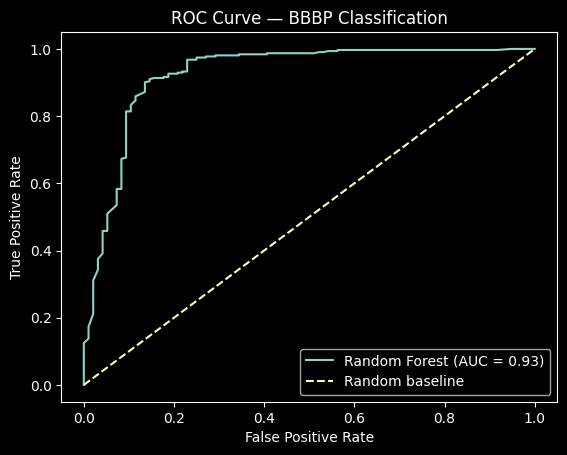

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — BBBP Classification")
plt.legend()
plt.show()

#### Connclusion:

- The Random Forest model outperforms the baseline ROC-AUC,
  indicating that it captures meaningful structure–property relationships.
- ROC-AUC is the primary metric, as it is robust to class imbalance.
- The model serves as a reasonable baseline for QSAR classification.

### Why Model Interpretation Matters

QSAR models are often used in drug discovery decision-making.
Therefore, it is critical to understand what the model learns
and what conclusions can (and cannot) be drawn from it.

Machine learning models in QSAR capture correlations,
not causal relationships.

In [32]:
# Random Forest estimates feature importance based on how much each feature reduces impurity across trees.

#In QSAR models using fingerprints, features correspond to fingerprint bits, not atoms or bonds.

importances = model.feature_importances_

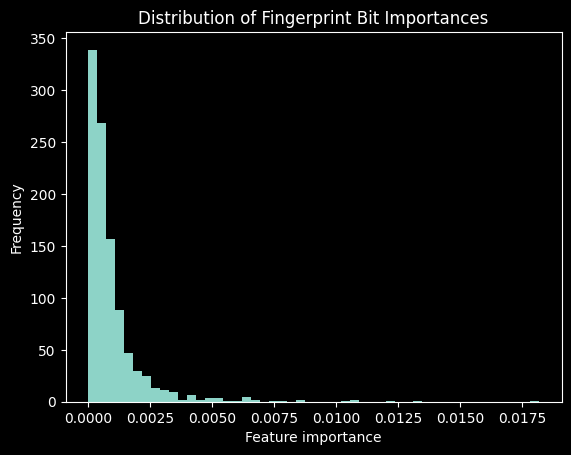

In [33]:
plt.figure()
plt.hist(importances, bins=50)
plt.xlabel("Feature importance")
plt.ylabel("Frequency")
plt.title("Distribution of Fingerprint Bit Importances")
plt.show()

In [ ]:
#Most fingerprint bits have very low importance.
#Only a small subset contributes significantly to the model.

In [34]:
# Top-N important bits
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]

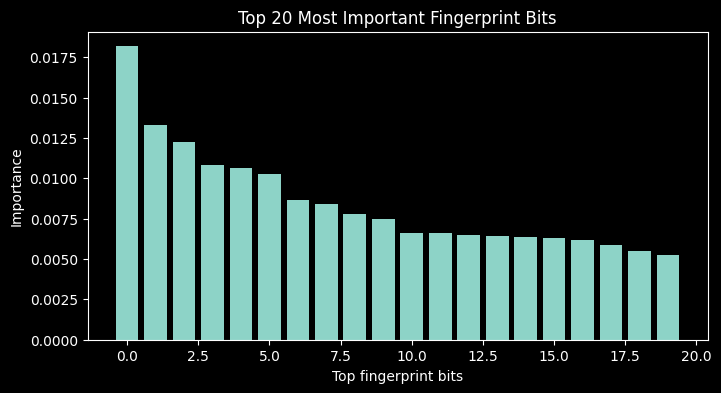

In [35]:
plt.figure(figsize=(8, 4))
plt.bar(range(top_n), importances[indices])
plt.xlabel("Top fingerprint bits")
plt.ylabel("Importance")
plt.title("Top 20 Most Important Fingerprint Bits")
plt.show()